Welcome to Homework 3! The goal of this homework is to better understand generative models by implementing Probabilistic PCA on your own.

Q1: Describe the model for PPCA in terms of the mean vector $\mu$, the matrix $B$ describing the linear transformation from the latent data $z$ to the observed data $x$, and the variance $\sigma^2$ of the isotropic Gaussian noise in the observed data. What are the model parameters that need to be estimated and what are their dimensions? When describing the probability model, be explicit regarding the dimensions of random variables/vectors. (5 points)

PPCA aims to identify a low-dimensional linear subspace (the loading matrix $B$), the mean $\mu$ of the data, and the variance $\sigma^2$ of the isotropic Gaussian noise in the observed data that maxamimze the likelihood of the observed data under a simple Gaussian latent variable model. In PPCA we’re doing a maximum‐likelihood fit of a Gaussian latent-variable model. 

In this way, PPCA provides a statistical foundation for dimensionality reduction by explicitly modeling the generative process of high-dimensional data. The model captures how low dimensional latent factors give rise to observed data through a linear transformation with uncertainty.

The PPCA model posits that each observed data point arises from the following process:

First, we consider a latent vector $z$ of dimension $m$, where $m$ is substantially smaller than the observed dimension $D$. This latent vector follows a standard Gaussian distribution in $m$-dimensional space, i.e. a cloud of probability centered at the origin with unit variance in all directions.

Next, this latent representation undergoes a linear transformation through the loading matrix $B$ (dimensions $D \times m$), which maps the low-dimensional latent space to the higher-dimensional observed space. This transformation captures the principal directions of variation in the data.

The transformed latent vector is then shifted by the mean vector $\mu$ (dimension $D$), representing the central tendency of the observed data distribution.

Finally, to account for measurement noise and variation not captured by the $m$ principal components, isotropic Gaussian noise with variance $\sigma^2$ is added independently to each dimension of the observed space.

This results in a conditional Gaussian distribution for the observed data given the latent variables, with mean $\mu + Bz$ and covariance $\sigma^2I_D$. When we marginalize out the latent variables, the observed data follows a Gaussian distribution with mean $\mu$ and covariance $BB^T + \sigma^2I_D$, decomposing the total variance into structured variation (captured by $BB^T$) and unstructured noise ($\sigma^2I_D$).

The parameters requiring estimation are:

* The mean vector $\mu$ (dimension $D$), represents the center of the data cloud
* The loading matrix $B$ (dimension $D \times m$), defines the principal subspace
* The noise variance $\sigma^2$ (a positive scalar), quantifies the residual variance



Q2: Based on your description, implement a function for generating `n` observations from a PPCA model, which takes in as arguments the mean vector $\mu$, the matrix $B$, the variance $\sigma^2$ of the isotropic Gaussian noise in the observed data, and the number of observations $n$. (5 points)

In [ ]:
import numpy as np

def generate_ppca(mu: np.ndarray, B: np.ndarray, sigma2: float, n: int) -> np.ndarray:
    """
    Generate n observations from a PPCA model:
        z ~ N(0, I_q)
        x = mu + B z + eps,   eps ~ N(0, sigma2 I_D)
    
    Args:
        mu     : np.ndarray of shape (D,) or (D,1) - the data mean
        B      : np.ndarray of shape (D, q) - the loading matrix
        sigma2 : float - noise variance
        n      : int - number of samples to draw

    Returns:
        X : np.ndarray of shape (n, D) - generated data points
    """
    mu = np.asarray(mu).reshape(1, -1)     # (1, D)
    B = np.asarray(B)                      # (D, q)
    D, q = B.shape

    # --- draw latent z’s ---
    Z = np.random.randn(n, q)              # (n, q)

    # --- map to data space ---
    XB = Z.dot(B.T)                        # (n, D)

    # --- add mean ---
    XB += mu                               # broadcast to (n, D)

    # --- add isotropic noise ---
    noise = np.random.randn(n, D) * np.sqrt(sigma2)
    X = XB + noise

    return X

Q3: What is the closed form solution for PPCA from maximum likelihood estimation? Provide the equations. Be explicit with all dimensions. Make sure all notation used is defined. (5 points)


**Assumptions**

* Observed data matrix $X \in \mathbb{R}^{n \times D}$ has **rows = observations** and **columns = features**.  
* Latent dimensionality $q < D$.  
* Generative model:  
  * Latent code $z \in \mathbb{R}^{q}$ with prior $p(z)=\mathcal{N}(0,I_q)$.  
  * Observation $x \mid z \sim \mathcal{N}(\mu + Bz, \sigma^{2} I_D)$.  
    * $\mu \in \mathbb{R}^{D}$ — mean of the data.  
    * $B \in \mathbb{R}^{D \times q}$ — loading (linear-map) matrix.  
    * $\sigma^{2}\in\mathbb{R}_{>0}$ — isotropic noise variance.  

---
    
  * **Parameters**:
    * $\mu \in \mathbb{R}^{D}$ — global mean vector with $D$ elements (one per feature)
    * $B \in \mathbb{R}^{D \times q}$ — loading matrix that maps each latent dimension to its effect on each observed dimension
      * Each column of $B$ represents how one latent factor influences all $D$ observed variables
      * Each row of $B$ represents how all $q$ latent factors influence one observed variable
    * $\sigma^{2} \in \mathbb{R}_{>0}$ — positive scalar representing the variance of the observation noise in each dimension
      * Isotropic defined as equal variance in all directions (spherical noise)
---
**Notation and variables:**
- $X \in \mathbb{R}^{n \times D}$: data matrix with $n$ observations and $D$ dimensions
- $x_n \in \mathbb{R}^D$: the $n$-th data point (row of $X$, written as a column vector)
- $q < D$: chosen dimensionality of the latent space/factors
- $\hat{\mu} \in \mathbb{R}^D$: estimated mean vector
- $x_n^c \in \mathbb{R}^D$: centered data point ($x_n - \hat{\mu}$)
- $S \in \mathbb{R}^{D \times D}$: sample covariance matrix
- $U \in \mathbb{R}^{D \times D}$: orthogonal matrix of eigenvectors of $S$
- $\Lambda \in \mathbb{R}^{D \times D}$: diagonal matrix of eigenvalues of $S$
- $\lambda_j \in \mathbb{R}$: $j$-th eigenvalue of $S$ (in descending order)
- $U_q \in \mathbb{R}^{D \times q}$: first $q$ columns of $U$ (principal eigenvectors)
- $\Lambda_q \in \mathbb{R}^{q \times q}$: diagonal matrix of first $q$ eigenvalues
- $\hat{\sigma}^2 \in \mathbb{R}_{>0}$: estimated isotropic noise variance
- $I_q \in \mathbb{R}^{q \times q}$: $q \times q$ identity matrix
- $R \in \mathbb{R}^{q \times q}$: arbitrary orthogonal rotation matrix
- $\hat{B} \in \mathbb{R}^{D \times q}$: estimated loading matrix
---

**Closed Form Solution**

1. **Data mean**  
   $\hat{\mu} = \frac{1}{n}\sum_{n=1}^n x_n \in \mathbb{R}^D$,  
   $x_n^c = x_n - \hat{\mu}$

2. **Sample covariance and eigen-decomposition**  
   $S = \frac{1}{n}\sum_{n=1}^n x_n^c (x_n^c)^{\top} = U\Lambda U^{\top}$,  
   
   where $U \in \mathbb{R}^{D \times D}$ is orthogonal and $\Lambda = \text{diag}(\lambda_1,\dots,\lambda_D)$ with $\lambda_1 \geq \cdots \geq \lambda_D$.

3. **Noise variance**  
   $\hat{\sigma}^2 = \frac{1}{D-q}\sum_{j=q+1}^{D}\lambda_j$, $\hat{\sigma}^2 \in \mathbb{R}$

4. **Loading matrix**  
   Let $U_q = [u_1,\dots,u_q] \in \mathbb{R}^{D \times q}$,  
   $\Lambda_q = \text{diag}(\lambda_1,\dots,\lambda_q) \in \mathbb{R}^{q \times q}$  
   
   For any orthogonal $R \in \mathbb{R}^{q \times q}$,  
   $\hat{B} = U_q (\Lambda_q - \hat{\sigma}^2 I_q)^{1/2} R$, $\hat{B} \in \mathbb{R}^{D \times q}$  
   
   A common choice is $R = I_q$.

Q4: Implement a function that performs maximum likelihood estimation for PPCA. The function should take in the observed data and the dimension of the latent factors $m$. It should return $\hat{\mu}, \hat{B},$ and $\hat{\sigma}^2$. (15 points)

In [ ]:
import numpy as np
from numpy.linalg import eigh

def ppca_mle(X: np.ndarray, m: int) -> tuple[np.ndarray, np.ndarray, float]:
    """
    Maximum–likelihood estimation for Probabilistic PCA (Tipping & Bishop, 1999).

    Parameters
    ----------
    X : ndarray of shape (n_samples, D)
        Observed data matrix. Rows are samples, columns are observed dimensions.
    m : int
        Latent dimensionality (number of principal components to retain).
        Must satisfy 1 ≤ m < D.

    Returns
    -------
    mu_hat : ndarray of shape (D,)
        Estimated data mean vector.
    B_hat : ndarray of shape (D, m)
        Estimated loading matrix (sometimes denoted W).
    sigma2_hat : float
        Estimated isotropic noise variance.

    Notes
    -----
    The solution maximises the likelihood under the PPCA model

        z  ~  N(0, I_m)
        x | z  ~  N(mu + B z, σ² I_D).

    The closed-form ML estimates are:

        μ̂      = sample mean  
        σ̂²     = (1/(D-m)) Σ_{j=m+1}^D λ_j  
        B̂      = U_m (Λ_m – σ̂² I)^{1/2} R

    where {λ_j, U_j} are the eigenpairs of the sample covariance matrix S,
    Λ_m = diag(λ_1, …, λ_m), and R is any orthogonal matrix (we take R = I).
    """
    # ---------- basic checks ----------
    if X.ndim != 2:
        raise ValueError("X must be a 2-D array (n_samples × D).")
    n, D = X.shape
    if not 1 <= m < D:
        raise ValueError(f"m must satisfy 1 ≤ m < D (= {D}).")

    # ---------- centre data ----------
    mu_hat = X.mean(axis=0)
    X_centered = X - mu_hat

    # ---------- sample covariance ----------
    # using (1/n) rather than (1/(n-1)) because we are in an ML setting
    S = (X_centered.T @ X_centered) / n      # shape: (D, D)

    # ---------- eigen-decomposition ----------
    # eigh returns ascending order; reverse for descending
    eigvals, eigvecs = eigh(S)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # ---------- noise variance ----------
    sigma2_hat = float(np.mean(eigvals[m:]))   # eq. (12) in Tipping & Bishop

    # ---------- loading matrix ----------
    # choose R = I (any orthogonal rotation is ML-equivalent)
    Lambda_m = np.diag(np.sqrt(np.maximum(eigvals[:m] - sigma2_hat, 0.0)))
    B_hat = eigvecs[:, :m] @ Lambda_m          # eq. (11)

    return mu_hat, B_hat, sigma2_hat

Q5: Test out your implementation of PPCA. Generate data using your function from Q2. Generate $n=1000$ observations with $m=2$ latent dimensions, $p=4$ observed dimensions, $\mu=\vec{0}_4$, $B = np.array([[1,1],[0,1],[1,0],[1,-1]])$, and $\sigma^2 = 0.25$. What are your estimates for the model parameters? How close are your estimated parameters for $\mu$ and $\sigma^2$ to the truth? To check your estimate for $B$, check that $\hat{B} \hat{B}^\top$ is close to $B B^\top$. (Hint: Your solution should be pretty close.) (5 points)

In [16]:
import numpy as np

# --- Set seed for reproducibility ---
np.random.seed(42)

# --- Define parameters ---
mu = np.zeros(4)
B = np.array([[1, 1],
              [0, 1],
              [1, 0],
              [1, -1]])
sigma = 0.25 
n = 1000

# --- Generate data ---

X = generate_ppca(mu = mu, B = B, sigma2 = sigma, n = n)

# --- Fit PPCA ---

mu_hat, B_hat, sigma2_hat = ppca_mle(X, m = 2)

# --- Compute estimates ---

BBT_hat = B_hat @ B_hat.T
BBT_true = B @ B.T

print("mu_hat:", mu_hat)
print("mu:", mu)
print("sigma2_hat:", sigma2_hat)
print("sigma:", sigma)
print("BBT_hat:", BBT_hat)
print("BBT_true:", BBT_true)

# --- Check estimates ---
mu_error = np.linalg.norm(mu_hat) if np.allclose(mu, 0) else np.linalg.norm(mu_hat - mu) / np.linalg.norm(mu)
print(f"Mean error: {mu_error:.6f}")
BBT_rel_error = np.linalg.norm(BBT_hat - BBT_true, 'fro') / np.linalg.norm(BBT_true, 'fro')
print(f"BBT relative error: {BBT_rel_error:.6f}")
sigma2_rel_error = abs(sigma2_hat - sigma) / sigma
print(f"Noise variance relative error: {sigma2_rel_error:.6f}")

# --- Validation ---
print("\nValidation results:")
print(f"Mean estimation: {'PASS' if mu_error < 0.10 else 'FAIL'}")
print(f"Covariance structure: {'PASS' if BBT_rel_error < 0.10 else 'FAIL'}")
print(f"Noise variance: {'PASS' if sigma2_rel_error < 0.10 else 'FAIL'}")


mu_hat: [ 0.10294883  0.03488957 -0.00653038 -0.02921555]
mu: [0. 0. 0. 0.]
sigma2_hat: 0.2460923471957588
sigma: 0.25
BBT_hat: [[ 1.99415744  1.03044633  0.95980023 -0.10536937]
 [ 1.03044633  1.04454757  0.00601647 -1.07027492]
 [ 0.95980023  0.00601647  0.93071995  0.92119547]
 [-0.10536937 -1.07027492  0.92119547  2.02068277]]
BBT_true: [[ 2  1  1  0]
 [ 1  1  0 -1]
 [ 1  0  1  1]
 [ 0 -1  1  2]]
Mean error: 0.112747
BBT relative error: 0.056227
Noise variance relative error: 0.015631

Validation results:
Mean estimation: FAIL
Covariance structure: PASS
Noise variance: PASS


Q6: We will now apply PPCA to the MNIST digit dataset, but only for images of the digit zero. Import and filter the MNIST digit dataset to only images of the digit zero using the following code. Then use the `visualize_digits` function to visualize the first four digits in this dataset. (1 point)
```
from sklearn import datasets
from matplotlib import pyplot as plt

# Load the data
digits = datasets.load_digits()

# filter for digit zero
zero_idxs = digits.target == 0
mnist0_imgs = digits.images[zero_idxs]

# flatten the images into vectors
mnist0_X = mnist0_imgs.reshape((len(mnist0_imgs), -1))

def visualize_digits(mnist_flattened_X):
    # This function will visualize the first 4 digits in the provided data
    _, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
    for ax, image in zip(axes, mnist_flattened_X):
        ax.set_axis_off()
        image = image.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
```

In [22]:
from sklearn import datasets
from matplotlib import pyplot as plt

# --- Load the data ---
digits = datasets.load_digits()

# --- Filter for digit zero ---
zero_idxs = digits.target == 0
mnist0_imgs = digits.images[zero_idxs]

# --- Flatten the images into vectors ---
mnist0_X = mnist0_imgs.reshape((len(mnist0_imgs), -1))

def visualize_digits(mnist_flattened_X):
    # This function will visualize the first 4 digits in the provided data
    _, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
    for ax, image in zip(axes, mnist_flattened_X):
        ax.set_axis_off()
        image = image.reshape(28, 28)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")

Q7: Apply your PPCA model fitting code to the MNIST dataset, restricting to only those images of the digit zero. Use latent dimension 3 to fit the PPCA model. (1 point)

In [23]:
import numpy as np
from sklearn.datasets import fetch_openml

# --- Load and filter MNIST zeros ---
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype(float)[mnist.target.astype(int) == 0] / 255.0  # (n_zeros, 784)

# --- Fit PPCA (latent dim = 3) ---
mu_hat, B_hat, sigma2_hat = ppca_mle(X, 3)

# --- Report shapes & noise variance ---
print(f"μ̂ shape: {mu_hat.shape}")
print(f"B̂ shape: {B_hat.shape}")
print(f"σ̂²: {sigma2_hat:.4f}")

μ̂ shape: (784,)
B̂ shape: (784, 3)
σ̂²: 0.0396


Q8: Now generate four images of the digit zero using your fitted model (use the function you implemented in Q2)! Visualize your generated images using the helper function `visualize_digits`. Note that you might need to cast the generated data to float and truncate any generated pixel values smaller than zero. (3 points)

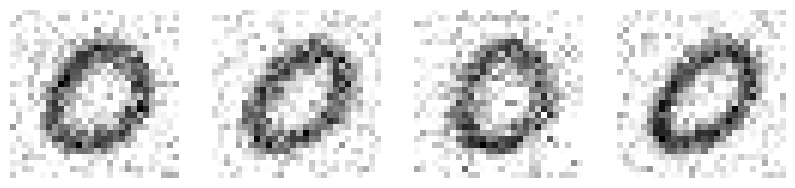

In [24]:
# --- Generate 4 new “0” images from the fitted PPCA model ---
X_gen = generate_ppca(mu_hat, B_hat, sigma2_hat, n=4).astype(float)

# --- Truncate negatives (pixels can’t go below 0) ---
X_gen = np.clip(X_gen, 0.0, None)

# --- Visualize with the provided helper (expects shape (n, 784)) ---
visualize_digits(X_gen)